### Installing Spark

Install Dependencies:


1.   Java 8
2.   Apache Spark with hadoop
3.   Findspark (used to locate the spark in the system)


In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget http://archive.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.6.tgz
!tar xf spark-2.4.8-bin-hadoop2.6.tgz

--2021-06-14 05:03:29--  http://archive.apache.org/dist/spark/spark-2.4.8/spark-2.4.8-bin-hadoop2.6.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 233849041 (223M) [application/x-gzip]
Saving to: ‘spark-2.4.8-bin-hadoop2.6.tgz’

spark-2.4.8-bin-had 100%[===================>] 223.02M  24.1MB/s    in 9.8s    

2021-06-14 05:03:39 (22.8 MB/s) - ‘spark-2.4.8-bin-hadoop2.6.tgz’ saved [233849041/233849041]



In [3]:
!pip -q install findspark graphframes

     |████████████████████████████████| 163kB 7.3MB/s 


Set Environment Variables:

In [4]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.8-bin-hadoop2.6"

os.environ["HADOOP_HOME"] = os.environ["SPARK_HOME"]
os.environ["PYSPARK_DRIVER_PYTHON"] = "jupyter"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"] = "notebook"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages graphframes:graphframes:0.8.0-spark2.4-s_2.11 pyspark-shell"

In [5]:
import findspark

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
# Property used to format output tables better
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

### Part 1
Create Graphframes

In [6]:
import re

# load vertexs as RDD
vertexs = spark.sparkContext.textFile('Vertex.txt')
v = vertexs.map(lambda line: re.split(r'\t+', line)).toDF(['id', 'name'])

# load edges as RDD
edges = spark.sparkContext.textFile('edges.txt')
e = edges.map(lambda line: re.split(r'\t+', line)).toDF(['src', 'dst'])

In [7]:
# Create a GraphFrame
from graphframes import *

g = GraphFrame(v, e)

### Part 2
1. Find vertex with most input degree
2. Find vertex with most output degree

In [20]:
res_df = g.inDegrees.orderBy('inDegree', ascending=False).limit(1)
res_df.join(v, 'id').show()

+------------------+--------+-------------------+
|                id|inDegree|               name|
+------------------+--------+-------------------+
|946065507707541358|     327|The Football League|
+------------------+--------+-------------------+



In [21]:
res_df = g.outDegrees.orderBy('outDegree', ascending=False).limit(1)
res_df.join(v, 'id').show()

+-------------------+---------+--------------------+
|                 id|outDegree|                name|
+-------------------+---------+--------------------+
|3841755165517709241|      264|Template:All-Irel...|
+-------------------+---------+--------------------+



### Part 3
Calculate connected components size

In [22]:
!mkdir /content/checkpoints

In [23]:
spark.sparkContext.setCheckpointDir('/content/checkpoints')

In [24]:
result = g.connectedComponents()

In [25]:
result.groupBy('component').count().orderBy('count', ascending=False).show()

+-------------+-----+
|    component|count|
+-------------+-----+
|            1| 6477|
|  42949672979|   52|
|  85899345921|   35|
| 163208757270|   14|
|   8589934631|   14|
|  77309411351|   13|
| 317827579922|   13|
|  68719476736|   12|
|  68719476765|   11|
|  34359738381|    9|
| 154618822695|    7|
|  17179869223|    7|
| 687194767374|    6|
| 137438953508|    6|
| 292057776177|    6|
| 420906795013|    6|
| 146028888100|    6|
| 446676598817|    6|
| 730144440335|    5|
|1108101562411|    5|
+-------------+-----+
only showing top 20 rows



### Part 4
Find top 10 vertex with most input degree

In [26]:
res_df = g.inDegrees.orderBy('inDegree', ascending=False).limit(10)
res_df.join(v, 'id').orderBy('inDegree', ascending=False).show()

+-------------------+--------+--------------------+
|                 id|inDegree|                name|
+-------------------+--------+--------------------+
| 946065507707541358|     327| The Football League|
|3856212023725725593|     322|National Football...|
|8978262722425160811|     316|Australian Footba...|
|6245498229508734555|     185|Southern Football...|
|7264519433548233535|     180|Football League F...|
|5362090331808156011|     179|Football League S...|
| 277710621679830671|     149|All-Ireland Senio...|
|1984578398767042266|     145|Scottish Football...|
|2395551540800395672|     134|Football League T...|
|5395033957924805072|     130|Pro Football Hall...|
+-------------------+--------+--------------------+



### Part 5
Draw 1 percent of graph as sample

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

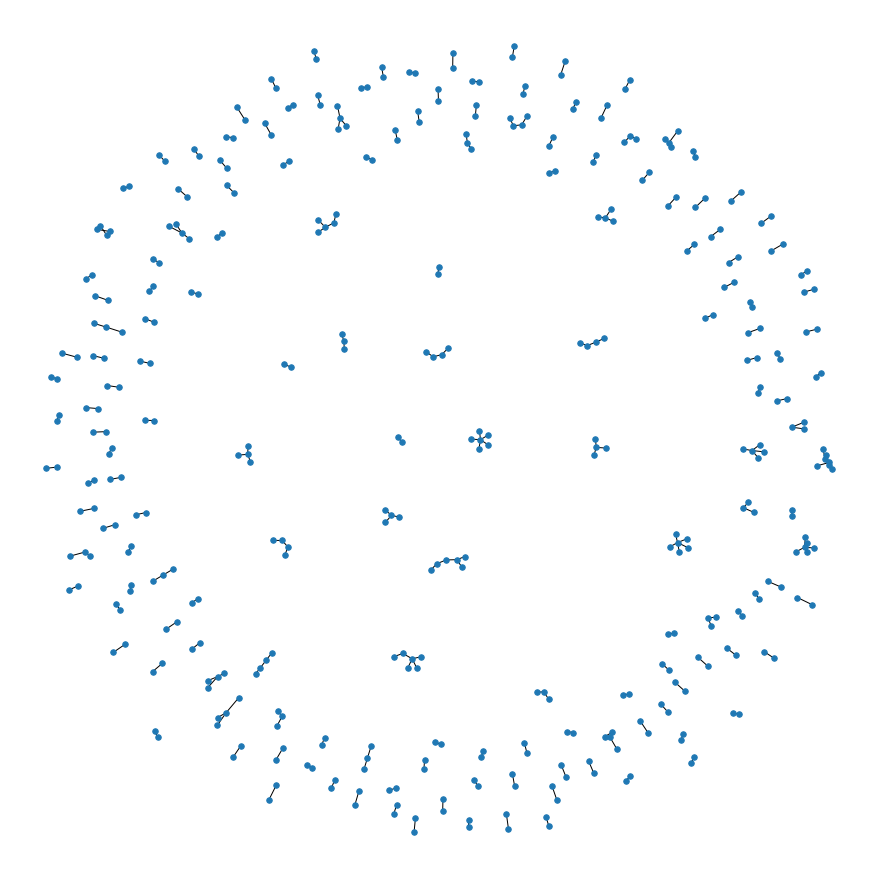

In [29]:
plt.figure(figsize=(12, 12))

pandas_df = g.edges.toPandas().sample(frac=0.01, random_state=85)
nx_g = nx.from_pandas_edgelist(pandas_df, source='src', target='dst')

nx.draw(nx_g, node_size=30)
plt.savefig('graph.jpg')